In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [6]:
start_date = "2019-01-01"
end_date = "2024-12-31"
tickers = ["SPY", "BTC-USD"]

data = yf.download(tickers, start=start_date, end=end_date)

# Wenn MultiIndex-Spalten vorhanden → 'Adj Close' extrahieren
if isinstance(data.columns, pd.MultiIndex):
    data = data["Close"]

data.dropna(inplace=True)
data.head()





[*********************100%***********************]  2 of 2 completed


Ticker,BTC-USD,SPY
Date,,
2019-01-02,3943.409424,226.285797
2019-01-03,3836.741211,220.886002
2019-01-04,3857.717529,228.284683
2019-01-07,4025.248291,230.084686
2019-01-08,4030.847900,232.246399


In [8]:
returns = data.pct_change().dropna()

eq_weights = np.array([0.5, 0.5])
eq_returns = (returns * eq_weights).sum(axis=1)
eq_cum_returns = (1 + eq_returns).cumprod()

w_6040 = np.array([0.6, 0.4])
r_6040 = (returns * w_6040).sum(axis=1)
cum_6040 = (1 + r_6040).cumprod()

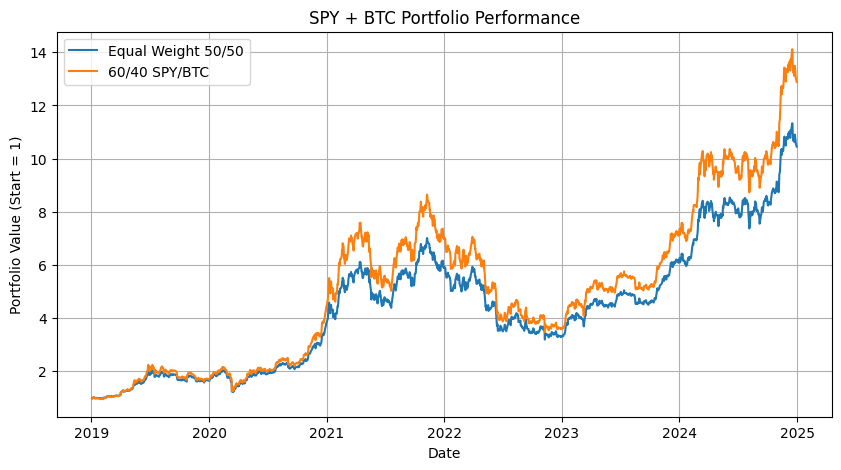

In [9]:
plt.figure(figsize=(10,5))
plt.plot(eq_cum_returns, label="Equal Weight 50/50")
plt.plot(cum_6040, label="60/40 SPY/BTC")
plt.title("SPY + BTC Portfolio Performance")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Start = 1)")
plt.legend()
plt.grid(True)
plt.show()



In [10]:
def sharpe_ratio(returns, rf=0.0):
    excess_returns = returns - rf / 252  # täglicher risikofreier Zins
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

print("Sharpe Ratio 50/50: ", round(sharpe_ratio(eq_returns), 2))
print("Sharpe Ratio 60/40: ", round(sharpe_ratio(r_6040), 2))


Sharpe Ratio 50/50:  1.25
Sharpe Ratio 60/40:  1.22


In [ ]:
## Log-Returns + Risk- free Sharp

In [1]:
import yfinance as yf, pandas_datareader.data as web, numpy as np, matplotlib.pyplot as plt
data = yf.download(["SPY", "BTC-USD"],
                   start="2019-01-01", end="2024-12-31")["Close"].dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [2]:
log_ret = np.log(data / data.shift(1)).dropna()

In [3]:
rf = (web.DataReader("TB3MS", "fred",
                     log_ret.index.min(), log_ret.index.max())/100)           # Jahres-%
rf = rf.resample("B").ffill().reindex(log_ret.index, method="ffill")/252   

In [15]:
w_eq   = np.array([0.5, 0.5])
w_6040 = np.array([0.6, 0.4])
w_6733 = np.array([0.67, 0.33])

lr_eq   = (log_ret * w_eq  ).sum(axis=1)
lr_6040 = (log_ret * w_6040).sum(axis=1)
lr_6733 = (log_ret * w_6733).sum(axis=1)

cum_eq   = np.exp(lr_eq.cumsum())
cum_6040 = np.exp(lr_6040.cumsum())
cum_6733 = np.exp(lr_6733.cumsum())

In [5]:
def sharpe(r, rf_series):                 # r & rf_series sind Series (daily)
    excess = r - rf_series
    return (excess.mean() / excess.std()) * np.sqrt(252)

sr_eq   = sharpe(lr_eq,   rf.iloc[:,0])
sr_6040 = sharpe(lr_6040, rf.iloc[:,0])

print(f"Sharpe 50/50 (log, RF): {sr_eq:.2f}")
print(f"Sharpe 60/40 (log, RF): {sr_6040:.2f}")

Sharpe 50/50 (log, RF): 0.87
Sharpe 60/40 (log, RF): 0.85


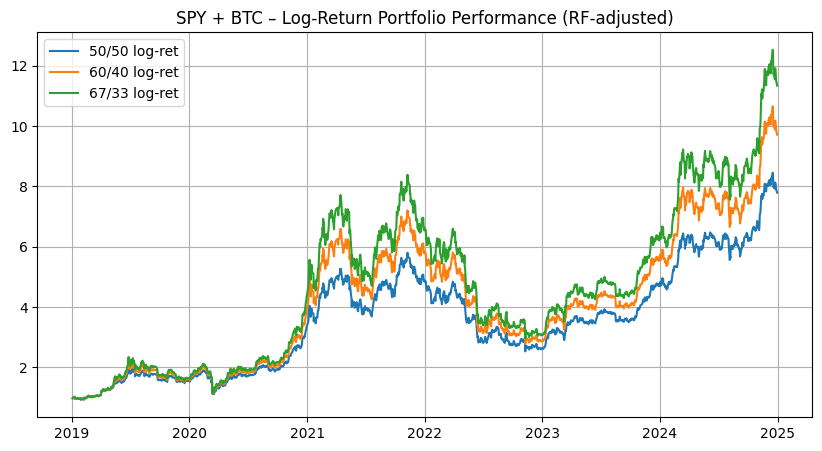

In [16]:
plt.figure(figsize=(10,5))
plt.plot(cum_eq,   label="50/50 log-ret")
plt.plot(cum_6040, label="60/40 log-ret")
plt.plot(cum_6733, label="67/33 log-ret")
plt.title("SPY + BTC – Log-Return Portfolio Performance (RF-adjusted)")
plt.legend(); plt.grid(True); plt.show()

In [7]:
# Log-Return Sharpe ohne Risk-Free (Vergleich)
def sharpe_norf(r):
    return (r.mean() / r.std()) * np.sqrt(252)

print("Sharpe 50/50 (log, ohne RF):", round(sharpe_norf(lr_eq), 2))
print("Sharpe 60/40 (log, ohne RF):", round(sharpe_norf(lr_6040), 2))


Sharpe 50/50 (log, ohne RF): 0.91
Sharpe 60/40 (log, ohne RF): 0.88


In [9]:
from scipy.optimize import minimize

def neg_sharpe(weights, returns, rf_series):
    port = (returns * weights).sum(axis=1)
    excess = port - rf_series
    return - (excess.mean() / excess.std()) * np.sqrt(252)

# Start: 50/50, Constraints: Sum = 1, Bounds: 0–1 pro Asset
bounds = ((0, 1), (0, 1))
constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
init_weights = [0.5, 0.5]

opt_result = minimize(
    neg_sharpe,
    x0 = init_weights,
    args = (log_ret, rf.iloc[:,0]),  # args der Funktion
    method = "SLSQP",
    bounds = bounds,
    constraints = constraint
)

print("Optimale Gewichtung für max. Sharpe:", opt_result.x)
print("Maximale Sharpe Ratio:", -opt_result.fun)


Optimale Gewichtung für max. Sharpe: [0.33359901 0.66640099]
Maximale Sharpe Ratio: 0.8852018225723598
